# Chapter 11: Deep Learning in the Cart Pole Game

New versions of MAC iOS doesn't support OpenGL, which means we need a workaround whenever the OpenAI Gym creates a game window. If you are using MAC, you can use this notebook for Chapter 11. 

In [1]:
import os

os.makedirs("files/ch11", exist_ok=True)

# 11.1. Play the Cart Pole Game in OpenAI Gym
Reminder: you need to install version 0.15.7 of gym. Don't pip install other versions of gym. See Chapter 10 if you need to switch version. 

## 11.1.1. Features of the Cart Pole Game 
Make sure the files CartPole.tar.gz and CartPoleUtil.py are both in this folder. Otherwise, download the files from the book's GitHub repository and place them in this folder (Desktop/mla/MAC/). 

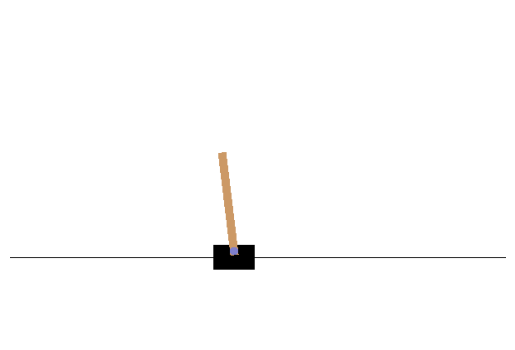

In [2]:
# make sure the file CartPole.tar.gz is in this folder
from CartPoleUtil import get_frame
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gym
env = gym.make("CartPole-v0")
obs=env.reset()
clear_output(wait=True)
plt.imshow(get_frame(obs))
plt.axis("off")
plt.show()    

In [3]:
# Print out all possible actions in this game
actions = env.action_space
print(f"The action space in the Cart Pole game is {actions}")

# Print out all possible states in this game
states = env.observation_space
print(f"The state space in the Cart Pole game is {states}")

The action space in the Cart Pole game is Discrete(2)
The state space in the Cart Pole game is Box(4,)


In [4]:
env.close()

## 11.1.2. Play A Full Game

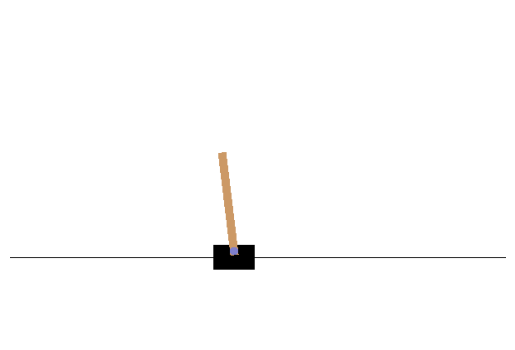

(array([ 0.0308981 , -0.15890008,  0.0384982 ,  0.31895491]), 1.0, False, {})
(array([ 0.0277201 , -0.35454858,  0.04487729,  0.62352588]), 1.0, False, {})
(array([ 0.02062913, -0.55026743,  0.05734781,  0.92999807]), 1.0, False, {})
(array([ 0.00962378, -0.74611459,  0.07594777,  1.24013689]), 1.0, False, {})
(array([-0.00529851, -0.94212515,  0.10075051,  1.55561237]), 1.0, False, {})
(array([-0.02414101, -0.74834433,  0.13186276,  1.29598571]), 1.0, False, {})
(array([-0.0391079 , -0.5551206 ,  0.15778247,  1.04732167]), 1.0, False, {})
(array([-0.05021031, -0.7519443 ,  0.17872891,  1.38508566]), 1.0, False, {})
(array([-0.0652492 , -0.94878729,  0.20643062,  1.7279137 ]), 1.0, False, {})
(array([-0.08422494, -1.14558436,  0.24098889,  2.07710242]), 1.0, True, {})


In [5]:
env.reset()  
results=[]
while True:
    action = actions.sample()
    print(action)
    new_state, reward, done, info = env.step(action)
    clear_output(wait=True)
    plt.imshow(get_frame(obs))
    plt.axis("off")
    plt.show()
    results.append((new_state, reward, done, info))  
    if obs[0]>=4.8 or obs[0]<=-4.8:
        env.reset()
    if obs[2]>=4.2 or obs[2]<=-4.2:
        env.reset()   
    if done == True:
        break
env.close() 
for x in results:
    print(x)

# 11.2. Generate Data to Train the Model

## 11.2.1. How to Define Winning and Losing?

## 11.2.2. Prepare Data for the Neural Network

First we’ll simulate one game and record the whole game history and the game outcome. The Python code in the cell below accomplishes that:

In [6]:
# Define one_game() function
def one_game():
    # lists to record all game histories and outcomes
    history = []
    winlose = []
    state = env.reset()
    while True:
        # randomly choose an action  
        action = env.action_space.sample()
        # make a move
        new_state, reward, done, _ = env.step(action)
        # recording game hisotry
        history.append([state,action,new_state,reward,done])
        # temporarily record the step as winning
        winlose.append(1)
        # prepare for the next round
        state = new_state
        # stop if the game is over
        if done==True:
            break  
    return history, winlose

In [7]:
from pprint import pprint

history, winlose = one_game()
# The last ten steps are considered not winning
for i in range(len(history)):
    if len(history)-i<=10:
        winlose[i] = 0
        
print("the game history is") 
pprint(history)  
print("the win/loss history is", winlose) 
print(f"the game has lasted {len(history)} steps") 
env.close()

the game history is
[[array([-0.0498601 , -0.0206725 , -0.02792365,  0.00214443]),
  0,
  array([-0.05027355, -0.21538309, -0.02788076,  0.28588797]),
  1.0,
  False],
 [array([-0.05027355, -0.21538309, -0.02788076,  0.28588797]),
  0,
  array([-0.05458121, -0.41009655, -0.02216301,  0.56964876]),
  1.0,
  False],
 [array([-0.05458121, -0.41009655, -0.02216301,  0.56964876]),
  0,
  array([-0.06278314, -0.60490077, -0.01077003,  0.85526794]),
  1.0,
  False],
 [array([-0.06278314, -0.60490077, -0.01077003,  0.85526794]),
  0,
  array([-0.07488116, -0.7998743 ,  0.00633533,  1.14454496]),
  1.0,
  False],
 [array([-0.07488116, -0.7998743 ,  0.00633533,  1.14454496]),
  0,
  array([-0.09087864, -0.99507844,  0.02922623,  1.43920786]),
  1.0,
  False],
 [array([-0.09087864, -0.99507844,  0.02922623,  1.43920786]),
  0,
  array([-0.11078021, -1.19054803,  0.05801038,  1.74087832]),
  1.0,
  False],
 [array([-0.11078021, -1.19054803,  0.05801038,  1.74087832]),
  0,
  array([-0.13459117, -1

In [8]:
# create lists to record all game histories and outcomes 
histories = []
winloses = []

# Play 10,000 games
for j in range(10000):
    # play a game
    history, winlose = one_game()
    for i in range(len(history)):
        if len(history)-i <= 10:
            winlose[i] = 0
    # record history and outcome
    histories.append(history)
    winloses.append(winlose)

Next, we'll save the simulated data on the computer for later use. 

In [9]:
import pickle
# save the simulation data on your computer
with open('CartPole_games.pickle', 'wb') as fp:
    pickle.dump((histories,winloses), fp)

The data set is saved as a pickle file in the folder /Desktop/mla/files/ch11/. 

You can load up the saved simulation data from your computer, and print out the first game, like so:

In [10]:
with open('CartPole_games.pickle', 'rb') as fp:
    histories, outcomes=pickle.load(fp)
    
pprint(histories[:1])    
pprint(outcomes[:1])  

# 11.3. Train the Deep Neural Network


## 11.3.1. Preprocess the Data


In [11]:
import numpy as np

# Create empty X and y lists
X, y = [], []    
# Create X and y for each game step
for history, winlose in zip(histories, outcomes):
    for i in range(len(history)):
        state, action, new_state, reward, done = history[i]
        s = np.array(state).reshape((4,1))
        a = np.array(action).reshape((1,1))
        sa = np.concatenate([s, a], axis = 0)
        # Each observation of X is a (state, action) combination
        X.append(sa.reshape(-1,))
        # Each y is the outcome for the state action combination
        y.append(winlose[i])
        
# Print the first five observations of X and y
from pprint import pprint
pprint(X[:5])
pprint(y[:5])
# See what's the average value of y
print(np.mean(np.array(y).reshape(-1,)))

[array([ 0.01333657, -0.0096225 ,  0.02801802, -0.01183272,  0.        ]),
 array([ 0.01314412, -0.20513483,  0.02778136,  0.2895569 ,  1.        ]),
 array([ 0.00904142, -0.01041982,  0.0335725 ,  0.00576376,  0.        ]),
 array([ 0.00883302, -0.20600676,  0.03368778,  0.30884731,  0.        ]),
 array([ 0.00471289, -0.40159211,  0.03986472,  0.61196121,  1.        ])]
[1, 1, 1, 1, 1]
0.5629370629370629


In [12]:
# save the processed data on your computer
with open('CartPoleXy.pickle', 'wb') as fp:
    pickle.dump((X,y),fp)

The data set is now ready to be fed into a deep neural network. 

## 11.3.2. Train the Deep Neural Network with Data


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# load the data       
with open('CartPoleXy.pickle', 'rb') as fp:
    X, y = pickle.load(fp)

X = np.array(X).reshape((-1, 5))
y = np.array(y).reshape((-1, 1))

# Create a model
model = Sequential()
model.add(Dense(64,activation='relu',input_shape=(5,)))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',
                   optimizer='adam', 
                   metrics=['accuracy'])

model.fit(X,y, epochs=50)
model.save('trained_cartpole.h5')

# 11.4. Play the Game with the Trained Model

## 11.4.1. A best_move() Function


In [14]:
def best_move(env,model):
    # curret state
    s = np.array(env.state).reshape((4,1))
    # action 0
    a0 = np.array([0]).reshape((1,1))
    sa0 = np.concatenate([s, a0], axis=0).reshape(-1,5)
    # action 1
    a1 = np.array([1]).reshape((1,1))    
    sa1 = np.concatenate([s, a1], axis=0).reshape(-1,5)
    # concatenate two state-action combinatoins
    sa = np.concatenate([sa0, sa1], axis=0).reshape(-1,5)
    # make predicitons using the trained model
    predictions = model.predict(sa, verbose=0)
    # pick the action with higher probability of winning
    return np.argmax(predictions)    

## 11.4.2. Play One Game

In [15]:
from tensorflow.keras.models import load_model
from copy import deepcopy

trained_model = load_model("trained_cartpole.h5")
state = env.reset()
frames = []
for i in range(1,201):
    # Use the trained model to select move
    action = best_move(env,trained_model)
    state, reward, done, info = env.step(action)
    # Save the screen for later use
    frames.append(get_frame(deepcopy(state)))   
    if done == True:
        # score is the number of steps staying upright
        print(f"score is {i}")
        break
env.close()

score is 200


# 11.5. Compare Two Games


## 11.5.1. Record A Game with Random Moves


In [16]:
state=env.reset()
random_frames=[]
# Record 200 frames
for i in range(1,201):
    # pick a random action 
    action=env.action_space.sample()
    # play the game
    state, reward, done, info=env.step(action)
    random_frames.append(get_frame(deepcopy(state)))
env.close()

## 11.5.2. Combine Frames
Next, we'll combine the two frames in each of the 200 steps. Make sure the file ch11util.py is in this folder.

In [17]:
from ch11util import combine_frames

combined = combine_frames(frames,random_frames)

We now have two lists: *frames* and *random_frames*. Each list has 200 frames. We want to combine the frames from the two lists in each step. If we have to save each combined frame on your computer, it's time-consuming. Further, it takes up too much space on your computer.  

Instead, we'll find a way to combine two frames without saving them. Here is how you can do it. You can save the pictures to your computer memory, using np.frombuffer() method. 

We now have 200 combined frames.

We'll use the ***imageio*** library to convert the 200 combined frames into an animation.

In [18]:
import imageio
imageio.mimsave('compare_cartpole.gif',
                combined, fps=20) 

The animation looks as follows:
<img src="https://gattonweb.uky.edu/faculty/lium/ml/compare_cartpole.gif" />

## 11.5.3. Subplots of the Cart Pole Game Stages


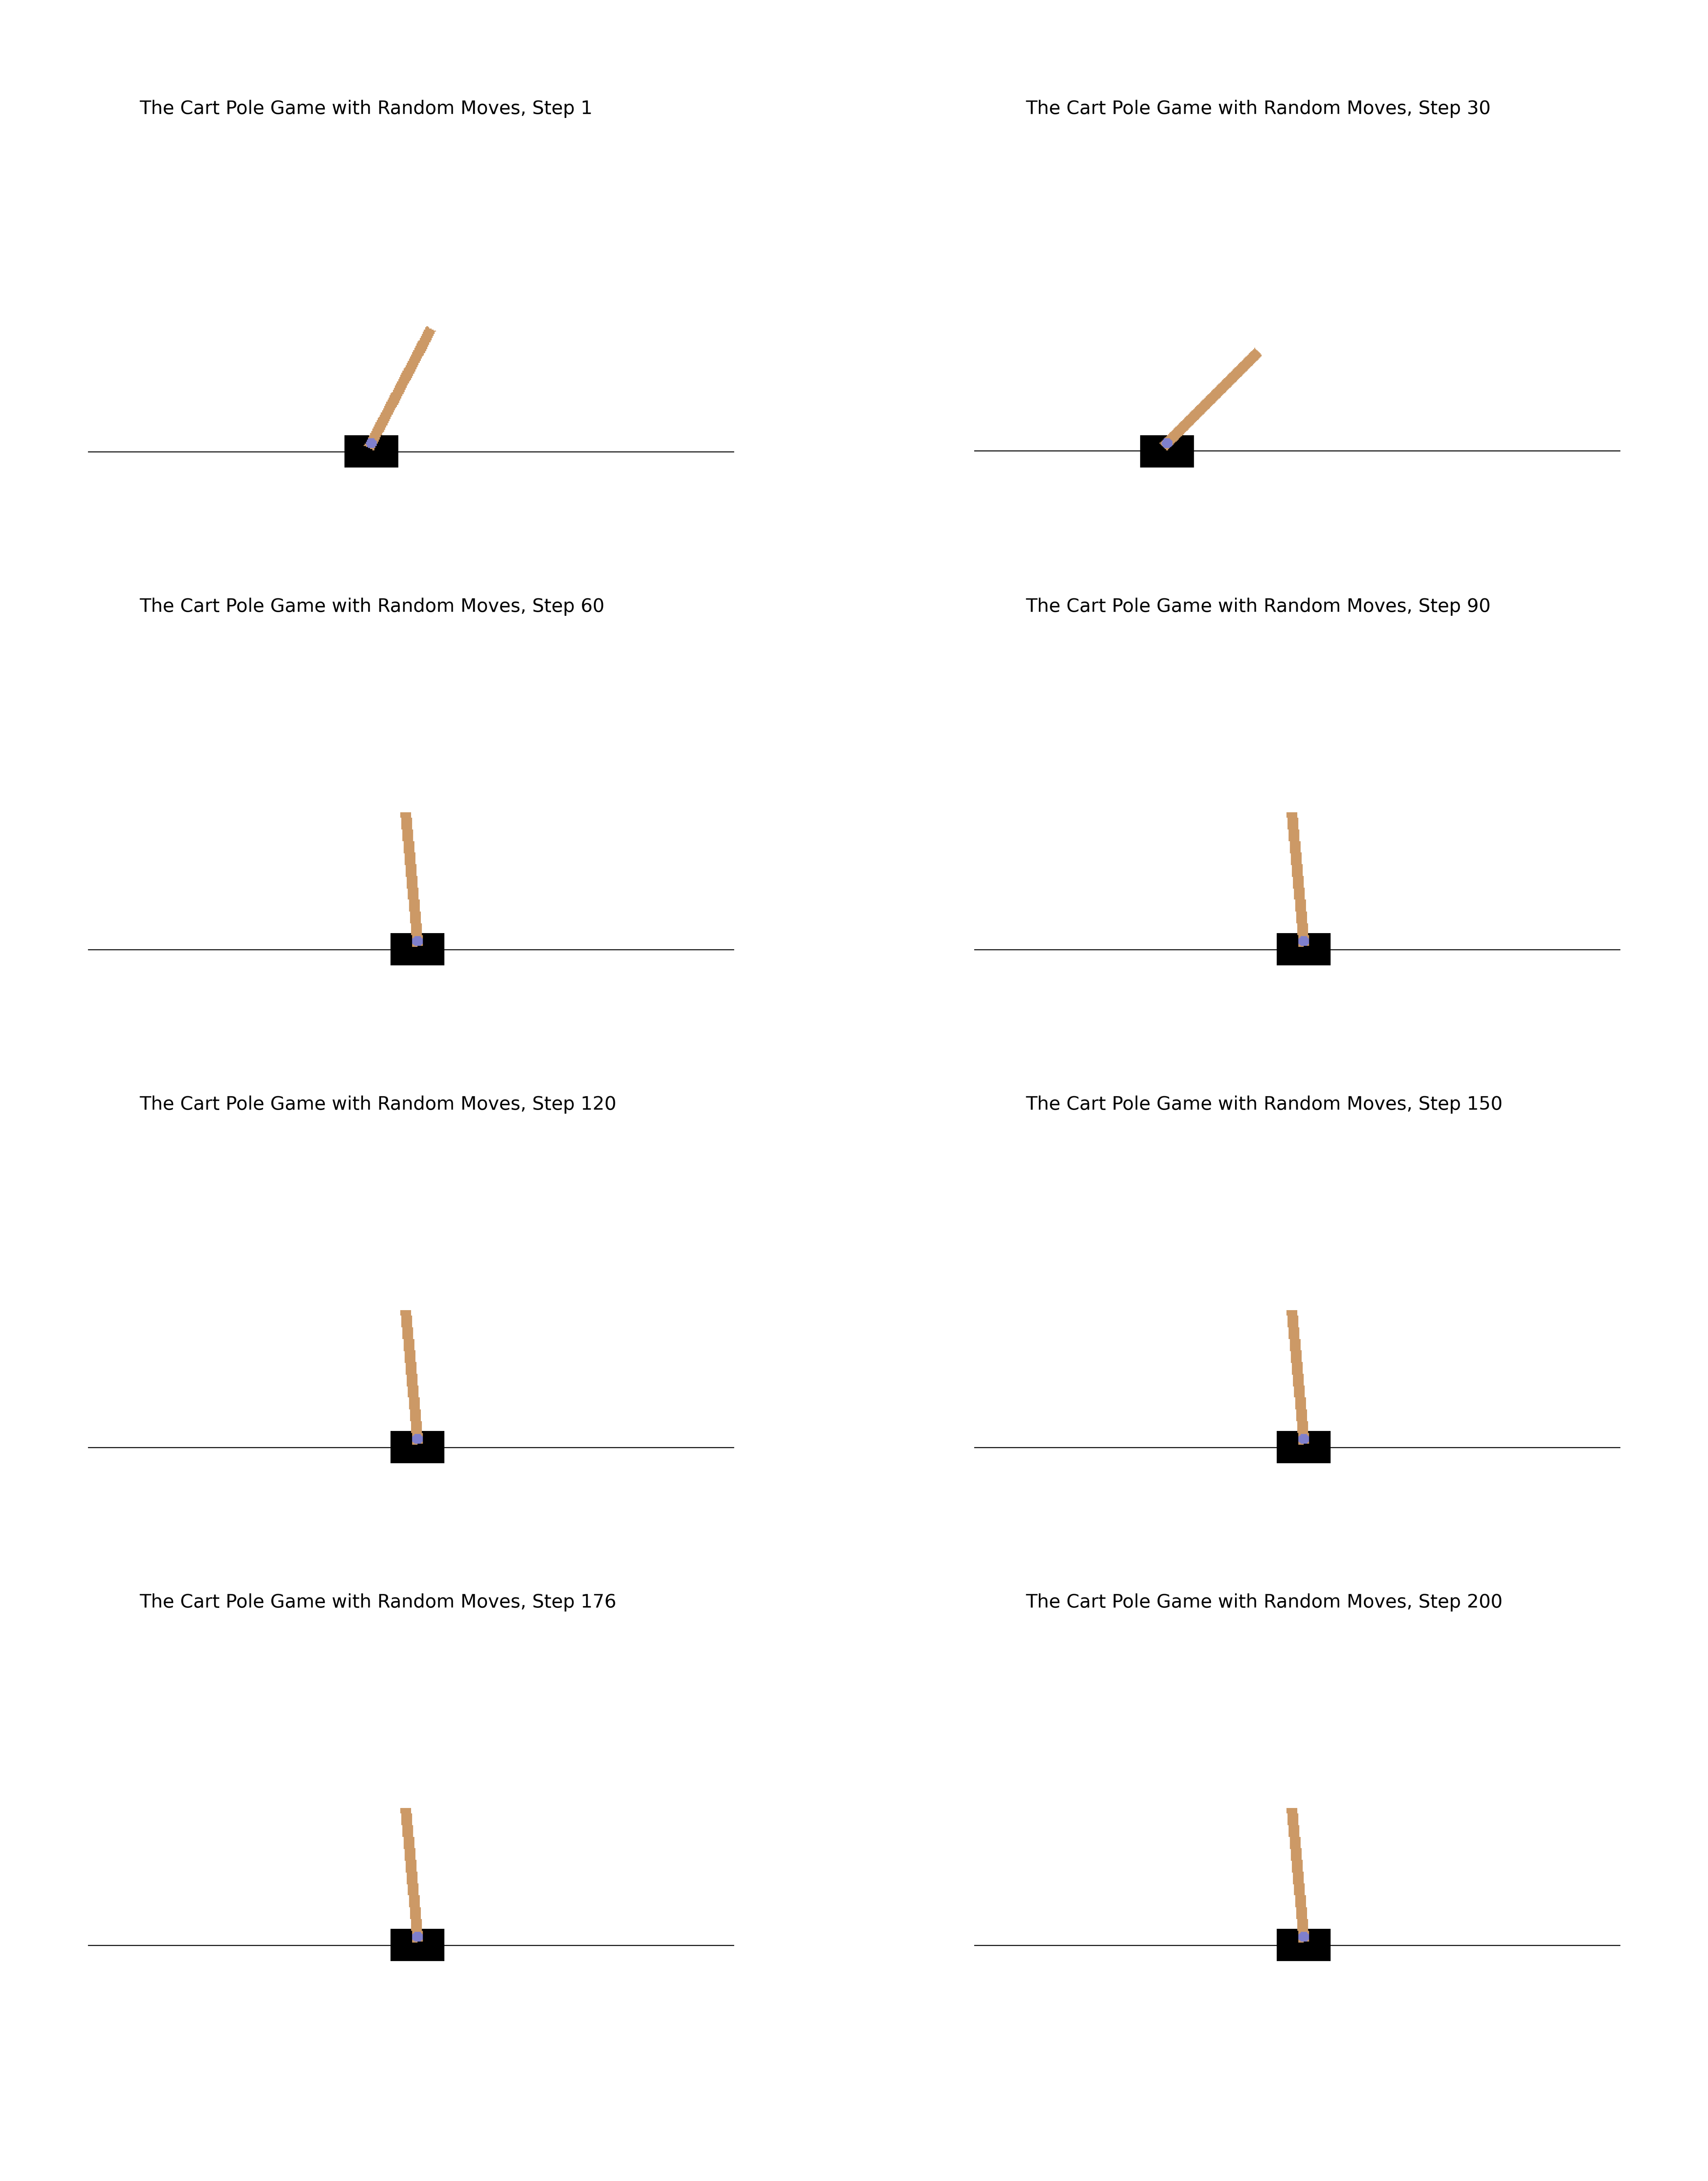

In [19]:
from ch11util import gen_subplots
from matplotlib import pyplot as plt

random_pics=gen_subplots(random_frames)
plt.figure(figsize=(28,30),dpi=200)
for i in range(8):
    plt.subplot(4,2,i+1)
    plt.imshow(random_pics[i])
    plt.axis('off')
plt.subplots_adjust(bottom=0.001,right=0.999,top=0.999,
        left=0.001, hspace=-0.26,wspace=-0.22)
plt.savefig("random_cartpole.png")

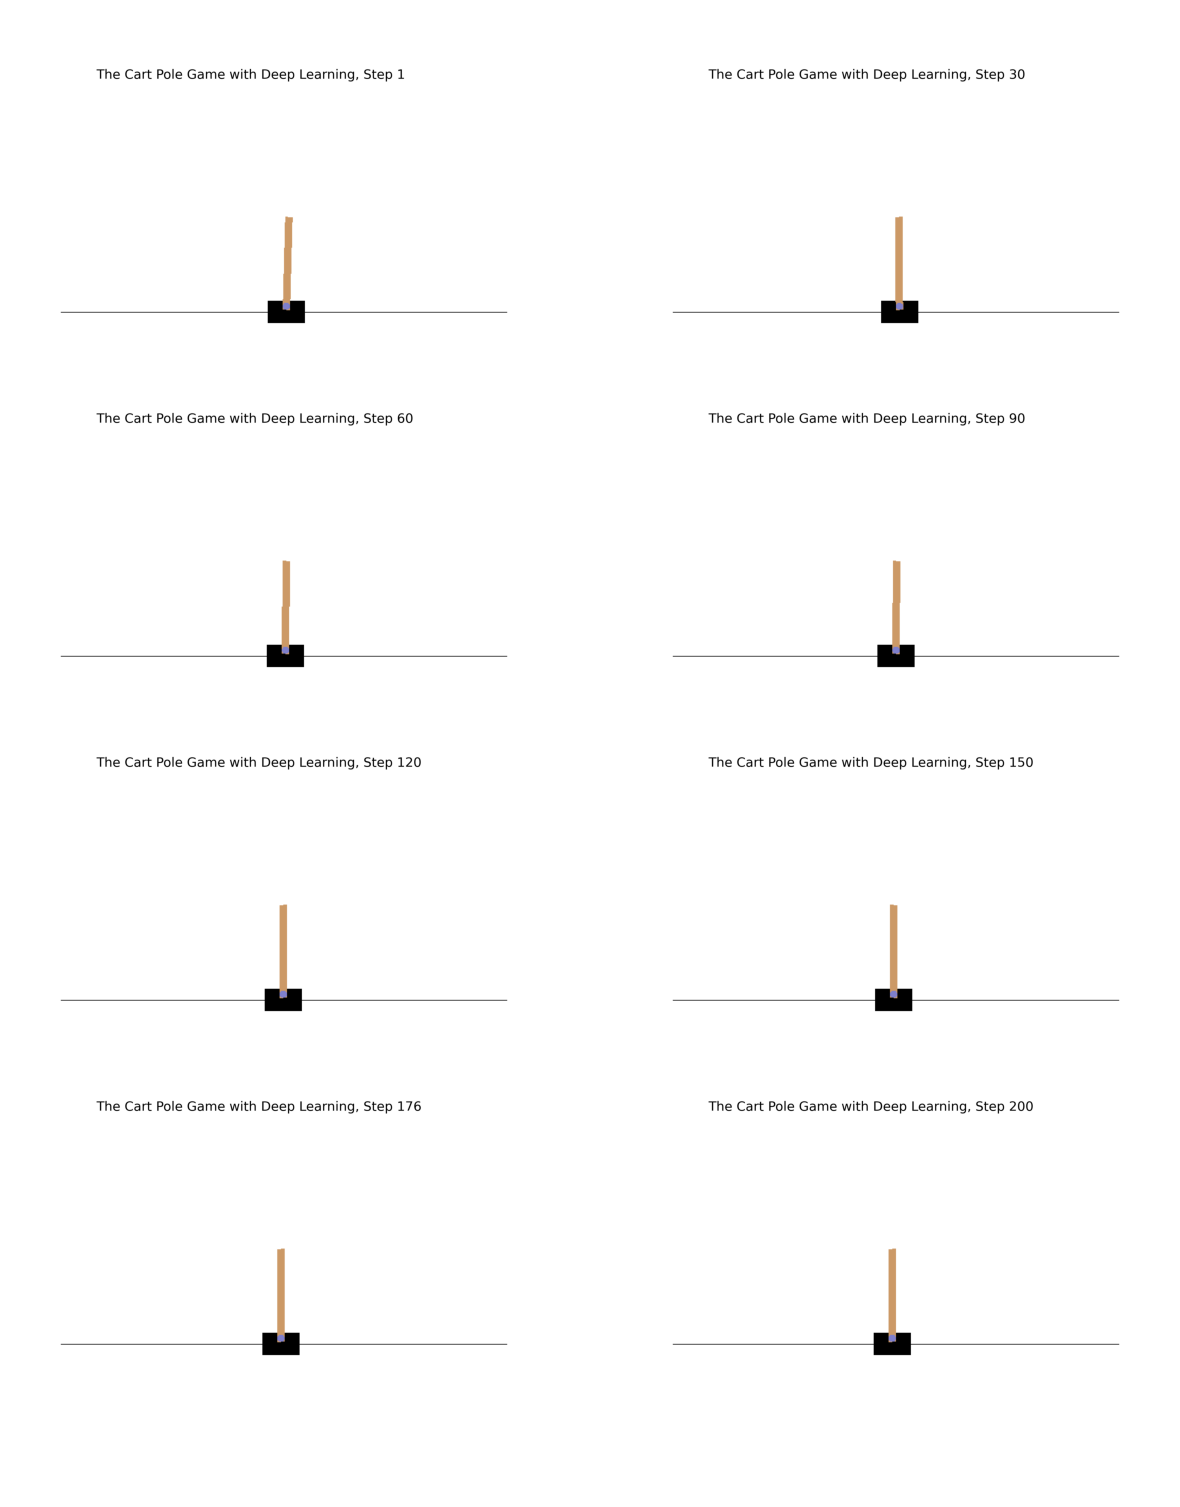

In [20]:
from utils.ch11util import subplots

pics=subplots(frames)
plt.figure(figsize=(28,30),dpi=50)
for i in range(8):
    plt.subplot(4,2,i+1)
    plt.imshow(pics[i])
    plt.axis('off')
plt.subplots_adjust(bottom=0.001,right=0.999,top=0.999,
        left=0.001, hspace=-0.26,wspace=-0.22)
plt.savefig("cartpole.png")

# 11.7 Exercises

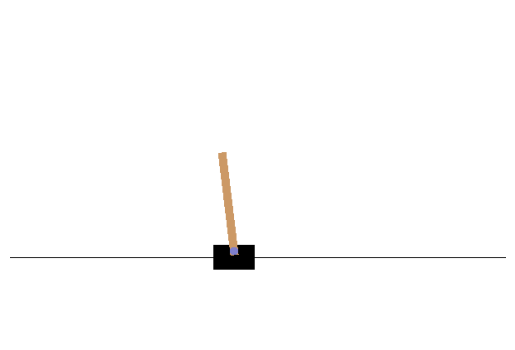

0
(array([-0.01621893, -0.21747984,  0.04214121,  0.32469098]), 1.0, False, {})
0
(array([-0.02056852, -0.41317569,  0.04863503,  0.63036   ]), 1.0, False, {})
0
(array([-0.02883204, -0.60894134,  0.06124223,  0.93795431]), 1.0, False, {})
0
(array([-0.04101086, -0.80483318,  0.08000132,  1.24923516]), 1.0, False, {})
0
(array([-0.05710753, -1.00088428,  0.10498602,  1.56586655]), 1.0, False, {})
0
(array([-0.07712521, -1.19709251,  0.13630335,  1.88936764]), 1.0, False, {})
0
(array([-0.10106706, -1.39340668,  0.1740907 ,  2.22105691]), 1.0, False, {})
0
(array([-0.1289352 , -1.58971062,  0.21851184,  2.56198648]), 1.0, True, {})


In [21]:
# answer to question 11.3
env.reset()  
results=[]
while True:
    action = 0
    new_state, reward, done, info = env.step(action)
    clear_output(wait=True)
    plt.imshow(get_frame(new_state))
    plt.axis("off")
    plt.show()
    results.append((new_state, reward, done, info))  
    if obs[0]>=4.8 or obs[0]<=-4.8:
        env.reset()
    if obs[2]>=4.2 or obs[2]<=-4.2:
        env.reset()   
    if done == True:
        break
env.close() 
for x in results:
    print(0)
    print(x)

In [22]:
# answer to question 11.4

from pprint import pprint

history, winlose = one_game()
# The last ten steps are considered not winning
for i in range(len(history)):
    if len(history)-i<=12:
        winlose[i] = 0
        
print("the game history is") 
pprint(history)  
print("the win/loss history is", winlose) 
print(f"the game has lasted {len(history)} steps") 
env.close()

the game history is
[[array([-0.00316748,  0.01580116,  0.03146694,  0.02029077]),
  0,
  array([-0.00285146, -0.1797576 ,  0.03187275,  0.32273344]),
  1.0,
  False],
 [array([-0.00285146, -0.1797576 ,  0.03187275,  0.32273344]),
  0,
  array([-0.00644661, -0.37531857,  0.03832742,  0.62529492]),
  1.0,
  False],
 [array([-0.00644661, -0.37531857,  0.03832742,  0.62529492]),
  0,
  array([-0.01395298, -0.57095402,  0.05083332,  0.92979808]),
  1.0,
  False],
 [array([-0.01395298, -0.57095402,  0.05083332,  0.92979808]),
  1,
  array([-0.02537206, -0.37655371,  0.06942928,  0.65351284]),
  1.0,
  False],
 [array([-0.02537206, -0.37655371,  0.06942928,  0.65351284]),
  0,
  array([-0.03290314, -0.57257025,  0.08249954,  0.96722509]),
  1.0,
  False],
 [array([-0.03290314, -0.57257025,  0.08249954,  0.96722509]),
  1,
  array([-0.04435454, -0.37864725,  0.10184404,  0.70155729]),
  1.0,
  False],
 [array([-0.04435454, -0.37864725,  0.10184404,  0.70155729]),
  0,
  array([-0.05192749, -0

In [23]:
# answer to question 11.5
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pickle
import numpy as np
# load the data       
with open('CartPoleXy.pickle', 'rb') as fp:
    X, y = pickle.load(fp)

X = np.array(X).reshape((-1, 5))
y = np.array(y).reshape((-1, 1))

# Create a model
model = Sequential()
model.add(Dense(64,activation='relu',input_shape=(5,)))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',
                   optimizer='adam', 
                   metrics=['accuracy'])

model.fit(X,y, epochs=50,verbose=0)
model.save('trained_cartpole2.h5')

In [24]:
# answer to question 11.6

from tensorflow.keras.models import load_model

trained_model = load_model("trained_cartpole2.h5")

state = env.reset()
frames = []
for i in range(1,201):
    # Use the trained model to select move
    action = best_move(env,trained_model)
    state, reward, done, info = env.step(action)
    clear_output(wait=True)
    plt.imshow(get_frame(state))
    plt.axis("off")
    plt.show()    
    if done == True:
        # score is the number of steps staying upright
        print(f"score is {i}")
        break
env.close()

score is 200
